# PPO :: re-wheeler project for Reacher UnityML environment
---

### 1. Import the Necessary Packages

In [1]:
import torch
from task import Task, update_goal_curyctor
from alchemy.bot import Bot, BrainDescription
from alchemy.env import Env

from utils.crossexp import *

from utils.encoders import *
from utils.rnn import *
import model

from utils.replay import ReplayBuffer

import matplotlib.pyplot as plt
%matplotlib inline

### 2. Load CONFIG :: TODO -> more implicit config ( trough .toml and all in one place, lot is now in 5th cell )

In [2]:
TOTAL_ENV = 20
STATE_SIZE = 33 - 3
ACTION_SIZE = 4
N_STEP = 10

N_HISTORY = 1#4#

N_REWARDS = 9
N_ACTORS = 1
MAX_STEPS = 60

### 3. Setup dummies ( unused feats in this environment )

In [3]:
def Encoder():
    return GlobalNormalizer(STATE_SIZE, N_HISTORY)

### 4. Set model wrappers

In [4]:
def Actor(encoder):
    nes_layers = [encoder.out_size(), 400, 300, ACTION_SIZE]
    return lambda: model.ActorFactory(nes_layers, torch.tanh, action_size=ACTION_SIZE, ddpg=False)

def Critic(encoder):
    return lambda: model.Critic(N_ACTORS, N_REWARDS, encoder.out_size(), ACTION_SIZE, lambda x: x)

def callback(bot, task, test_scores, learn_scores, seeds, total):
    if test_scores is None:
        return
    print("\n\t==> test round with ", len(test_scores), test_scores, np.mean(learn_scores))
def dbgout(bot, score, actions):
    return


### 5. Setup && run agent/bot

In [5]:
PPO_LOOP = 3
bs = 4096

learning_delay = MAX_STEPS * PPO_LOOP

replay_ddpg = ReplayBuffer(
            n_step=N_STEP, replay_reanalyze=True,
            buffer_size=learning_delay * TOTAL_ENV * 2, select_count=40, max_ep_draw_count=40,
            alpha=.7, beta_base=.3, beta_end=.7, beta_horizon=10000,
            recalc_delta=3)

encoder = Encoder()
brain_descriptions = [
        BrainDescription( # master :: PPO
            ddpg=False,
            count=TOTAL_ENV, n_groups=TOTAL_ENV, Actor=Actor(encoder), Critic=Critic(encoder),
            model_path="x_ppo_checkpoints", save=True, load=True, delay=1,
            resample_delay=N_STEP,
            good_reach=1, replay_buffer=replay_ddpg, batch_size=bs,
            sync_delta=3, learning_delay=learning_delay, learning_repeat=TOTAL_ENV * 3,
            fresh_frac=10, optim_epochs=3,
            ppo_eps=2e-1, dbgout=False,
            adv_on=True, adv_boost=False,                
            tau_replay_counter=1, tau_base=1e-3, tau_final=1e-3,
            replay_cleaning=False, prob_treshold=None),
    ]

bot = Bot(
# brain configs
        encoder,
        brain_descriptions,

        n_actors=2, n_critics=1,
        n_history=N_HISTORY, state_size=STATE_SIZE, action_size=ACTION_SIZE,
        lr_actor=1e-4, lr_critic=5e-5, clip_norm=5.,
        n_step=N_STEP, floating_step=True, gamma=.99,        

# agent configs
        update_goal=update_goal_curyctor(N_STEP),
        her_max_ratio=1,
        gae=True, gae_tau=.95,
        freeze_delta=3, freeze_count=3,
        )

task = Task()

env = Env(bot, task,
        total_envs=TOTAL_ENV, n_history=N_HISTORY, history_features=encoder.features_n(), state_size=encoder.in_size(),
        n_step=N_STEP, send_delta=N_STEP * 3,
        eval_limit=10, eval_ratio=.5, max_n_episode=MAX_STEPS, eval_delay=20,
        mcts_random_cap=1000, mcts_rounds=1)

scores = env.start(callback, dbgout)
losses = bot.brains[0].get_losses()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


[   20>  1219:: 0] steps =   60, max_step =  61/ 60, reward=-0.050778 <action=[0.0637968  0.75445002 0.406823   0.02592405]>                                        
	==> test round with  1 [0.3289999926462773] -0.05161111111111111
[   40>  2439:: 0] steps =   60, max_step =  61/ 60, reward=-0.025556 <action=[ 0.52156065  2.54799751 -1.03042568  0.90433116]>                                    
	==> test round with  1 [0.17399999611079672] -0.02633333333333333
[   60>  3659:: 0] steps =   60, max_step =  61/ 60, reward=-0.007889 <action=[-0.75563338  0.96489358  1.10768402 -0.55587169]>                                    
	==> test round with  1 [0.3754999916069214] -0.0085
[   80>  4879:: 0] steps =   60, max_step =  61/ 60, reward=-0.010389 <action=[-1.3486205   0.66994146  2.00697829 -1.95518741]>                                    
	==> test round with  1 [0.7384999834932419] -0.01077777777777778
[  100>  6099:: 0] steps =   60, max_step =  61/ 60, reward=-0.001889 <action=[ 0.503625

[  740> 45139:: 0] steps =   60, max_step =  61/ 60, reward=0.082722 <action=[-0.6567494   0.96556741  1.20294896  0.22833524]>                                     
	==> test round with  1 [23.667499470990162] 0.08461111111111112
[  760> 46359:: 0] steps =   60, max_step =  61/ 60, reward=0.100556 <action=[-0.10272727  0.50201502 -0.36531323 -0.07291312]>                                     
	==> test round with  1 [23.293999479338556] 0.10283333333333336
[  780> 47579:: 0] steps =   60, max_step =  61/ 60, reward=0.094222 <action=[ 0.30193    -1.37780955 -1.42493042  0.86421534]>                                     
	==> test round with  1 [24.230499458406143] 0.09633333333333333
[  800> 48799:: 0] steps =   60, max_step =  61/ 60, reward=0.098222 <action=[ 0.35957017  0.15804471 -0.94645844  1.82438569]>                                     
	==> test round with  1 [24.01799946315585] 0.10044444444444446
[  820> 50019:: 0] steps =   60, max_step =  61/ 60, reward=0.104722 <action=[ 0.

In [6]:
scores_ex = scores[1:]
scores = np.asarray(scores_ex).flatten()
losses_ex = losses
losses = np.vstack(losses_ex)[::len(losses_ex)//200]

### 4. Plot reward + loss

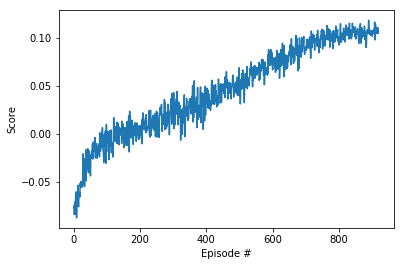

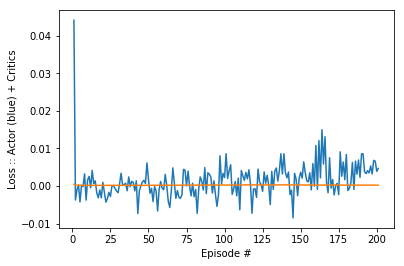

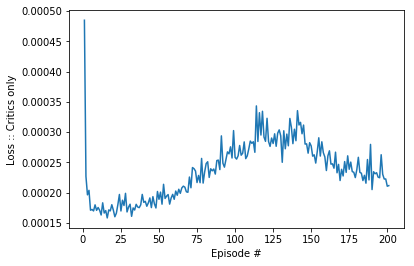

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show() 

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses)+1), losses)
plt.ylabel('Loss :: Actor (blue) + Critics')
plt.xlabel('Episode #')
plt.show() 

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses)+1), losses[:, 1:])
plt.ylabel('Loss :: Critics only')
plt.xlabel('Episode #')
plt.show() 

### 4. Reload trained agent

In [8]:
bot.sync_target(0, 0, [])
bot.sync_explorer(0, 0, [])

### 5. Test visuals - TARGET


 environment solved!  30.346349321706196
[32.311999277770475, 31.13099930416794, 28.920499353576417, 28.864999354817012, 31.11649930449202, 30.602999315969658, 31.526499295327767, 30.99649930717414, 27.816499378252708, 30.175999325513835]

 environment solved!  30.288499322999286
[30.19749932503331, 31.705999291315727, 31.44899929706011, 31.210999302379832, 30.357999321445835, 29.20049934731797, 28.76549935704103, 29.831999333202816, 31.151499303709738, 29.013999351486518]

 environment solved!  30.32154932226056
[30.00099932942541, 30.410499320272333, 30.848999310471147, 30.371499321144118, 29.931499330978838, 29.580999338813186, 29.578499338869033, 31.134499304089708, 29.797999333962842, 31.559999294578976]

 environment solved!  30.50864931807853
[30.268999323435093, 30.631499315332622, 30.14499932620671, 30.242499324027452, 29.296999345161005, 31.23049930194394, 30.186499325279158, 29.147499348502574, 32.42999927513304, 31.506999295763652]

 environment solved!  30.495499318372453

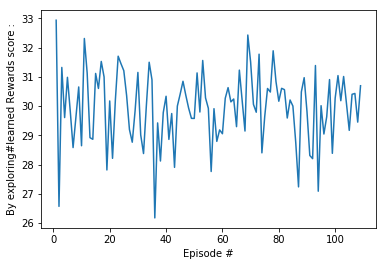

In [9]:
rewards = []
while len(rewards) < 100:
    success, scores = env.evaluate()
    for s in np.asarray(scores).flatten():
        rewards.append(s)
        
print("mean rewards : ", np.mean(rewards))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards)+1), rewards)
plt.ylabel('By exploring#learned Rewards score :')
plt.xlabel('Episode #')
plt.show()

### 6. Test visuals - EXPLORER

mean rewards :  24.304134456760245


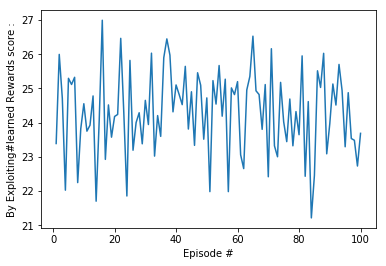

In [10]:
# for evaluation we will set target network to be explorer
bot.brains[0].ac_target = bot.brains[0].ac_explorer

rewards = []
while len(rewards) < 100:
    success, scores = env.evaluate()
    for s in np.asarray(scores).flatten():
        rewards.append(s)
        
print("mean rewards : ", np.mean(rewards))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards)+1), rewards)
plt.ylabel('By Exploiting#learned Rewards score :')
plt.xlabel('Episode #')
plt.show() 